# LSTM

# 1. Schritt: Audio-Dateien laden und in MFCCs umwandeln

In [1]:
import sys

import numpy as np
import os
sys.path.append(os.path.abspath(".."))

from feature_extraction import get_mfccs_from_coswara_audio_files
from feature_extraction import get_mfccs_from_virufy_audio_files
from feature_extraction import get_mfccs_from_coughvid_audio_files
from feature_extraction import get_valid_coswara_folder_names

labels_dict = {0: "neg", 1: "pos"}

labels, mfccs = [], []

p_folder_names, n_folder_names = get_valid_coswara_folder_names()

# Umwandlung der Coswara-Audio-Dateien in MFCCss
p_coswara_mfccs, p_coswara_labels = get_mfccs_from_coswara_audio_files(
    p_folder_names, is_positive=True
)

n_coswara_mfccs, n_coswara_labels = get_mfccs_from_coswara_audio_files(
    n_folder_names, is_positive=False
)

print("Positive Coswara samples: ", len(p_coswara_mfccs))
print("Negative Coswara samples: ", len(n_coswara_mfccs))

# Umwandlung der Virufy-Audio-Dateien in MFCCs
p_virufy_mfccs, p_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=True
)
n_virufy_mfccs, n_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=False
)

print("Positive Virufy samples: ", len(p_virufy_mfccs))
print("Negative Virufy samples: ", len(n_virufy_mfccs))

n_coughvid_folder_names = "neg"
p_coughvid_folder_names = "pos"

# Umwandlung der Coughvid-Audio-Dateien in MFCCs
p_coughvid_mfccs, p_coughvid_labels = get_mfccs_from_coughvid_audio_files(
    n_coughvid_folder_names,
    is_positive=True
)
n_coughvid_mfccs, n_coughvid_labels = get_mfccs_from_coughvid_audio_files(
    p_coughvid_folder_names,
    is_positive=False
)

print("Positive Coughvid samples: ", len(p_coughvid_mfccs))
print("Negative Coughvid samples: ", len(n_coughvid_mfccs))

mfcc = np.concatenate(
    (p_coswara_mfccs, n_coswara_mfccs, p_virufy_mfccs, n_virufy_mfccs,
     p_coughvid_mfccs, n_coughvid_mfccs)
)

labels = np.concatenate(
    (p_coswara_labels, n_coswara_labels, p_virufy_labels, n_virufy_labels,
     p_coughvid_labels, n_coughvid_labels)
)

mfcc = np.array(mfcc, dtype=np.float32)

labels = np.array(labels, dtype=np.int32)

print(len(mfcc), len(labels))


2025-03-06 07:19:07.427922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Positive Coswara samples:  1356
Negative Coswara samples:  3098
Positive Virufy samples:  7
Negative Virufy samples:  9
Positive Coughvid samples:  9983
Negative Coughvid samples:  924
15377 15377


# 2. Schritt: Aufteilen der Daten in Trainings- und Testdaten

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Labels in One-Hot-Encoding umwandeln
labels = to_categorical(labels, num_classes=2)

# Train-Test-Split durchführen
# 80% Training, 20% Test
mfcc_train, mfcc_test, labels_train, labels_test = train_test_split(
    mfcc, labels, test_size=0.2, random_state=42
)

print(
    f"""mfcc_train.shape: {mfcc_train.shape},
    labels_train.shape: {labels_train.shape}"""
)
print(
    f"""mfcc_test.shape: {mfcc_test.shape},
    labels_test.shape: {labels_test.shape}"""
)


mfcc_train.shape: (12301, 128, 1),
    labels_train.shape: (12301, 2)
mfcc_test.shape: (3076, 128, 1),
    labels_test.shape: (3076, 2)


# 3. Schritt: Erstellen des LSTM-Modells

In [3]:
# Konfiguration des Trainingsprozesses
BATCH_SIZE = 64
EPOCHS = 20
ACTIVATION_1 = "relu"
ACTIVATION_2 = "softmax"
METRIC = "accuracy"
LOSS = "binary_crossentropy"
OPTIMIZER = "adam"


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout

def build_lstm(*, isBidirectional: bool) -> Sequential:
    input_shape = mfcc[0].shape

    # model = Sequential([
    #     Input(shape=input_shape),
    #     # Adding more LSTM layers with dropout
    #     Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    #         Dropout(0.3),
    #         Bidirectional(LSTM(64)) if isBidirectional else LSTM(64),
    #         Dropout(0.3),
    #         BatchNormalization(),
    #         Dense(64, activation=ACTIVATION_1,
    #                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #         Dropout(0.2),
    #         Dense(len(labels_dict), activation=ACTIVATION_2)
    #     ])

    # Alternative Modelle:
    if isBidirectional:
        model = Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(128)),
            Dense(len(labels_dict), activation=ACTIVATION_2),
        ])
    else:
        model = Sequential([
            Input(shape=input_shape),
            LSTM(128),
            Dense(len(labels_dict), activation=ACTIVATION_2),
        ])

    model.summary()
    return model


## 3.1. Modell erstellen

In [5]:
bidirectional_model = build_lstm(isBidirectional=True)
bidirectional_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 133,634
Trainable params: 133,634
Non-trainable params: 0
_________________________________________________________________


In [6]:
model = build_lstm(isBidirectional=False)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________


In [7]:
def train_and_wandbLog(
    model, mfcc_train, labels_train, mfcc_test, labels_test, *, with_future: bool
):
    """Trainiert das Modell und loggt die Metriken in Weights & Biases.

    :param model: Modell, das trainiert werden soll
    :param mfcc_train: Trainingsdaten (MFCCs)
    :param labels_train: Trainingsdaten (Labels)
    :param mfcc_test: Testdaten (MFCCs)
    :param labels_test: Testdaten (Labels)
    :param with_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: History-Objekt des Trainingsprozesses
    """
    # Auskommentieren um Weights & Biases zu verwenden
    # import wandb

    # wandb.init(
    #     project="cnn_covid_audio_classification",
    #     config={
    #         "batch_size": BATCH_SIZE,
    #         "epochs": EPOCHS,
    #         "architecture": "CNN",
    #         "dataset": "coswara + virufy + coughvid",
    #         "activation_1": ACTIVATION_1,
    #         "activation_2": ACTIVATION_2,
    #         "metric": METRIC,
    #         "loss": LOSS,
    #         "optimizer": OPTIMIZER,
    #     },
    # )

    # WandB Run Name setzen
    FUTURE = "FUTURE" if with_future else "NO_FUTURE"
    # wandb.run.name = f"{FUTURE}_batch_size_{BATCH_SIZE}_epochs_{EPOCHS}_activation_1_{ACTIVATION_1}_activation_2_{ACTIVATION_2}_metric_{METRIC}_loss_{LOSS}_optimizer_{OPTIMIZER}"

    # history = model.fit(
    #     mfcc_train,
    #     labels_train,
    #     epochs=EPOCHS,
    #     batch_size=BATCH_SIZE,
    #     validation_data=(mfcc_test, labels_test),
    #     # callbacks=[
    #     #     wandb.keras.WandbMetricsLogger(log_freq=5),
    #     #     wandb.keras.WandbModelCheckpoint("models"),
    #     # ],
    # )

    history = model.fit(
        mfcc_train,
        labels_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(mfcc_test, labels_test),
    )

    # wandb.finish()
    return history


In [8]:
# Training des Modells
history = train_and_wandbLog(
    model, mfcc_train, labels_train, mfcc_test, labels_test, with_future=True
)
test_loss, test_acc = model.evaluate(mfcc_test, labels_test, verbose=2)

print("\nTest accuracy:", test_acc)
test_loss, test_acc = model.evaluate(mfcc_test, labels_test, verbose=2)


Epoch 1/20
193/193 [==============================] - 16s 78ms/step - loss: 0.5739 - accuracy: 0.7364 - val_loss: 0.5791 - val_accuracy: 0.7328
Epoch 2/20
193/193 [==============================] - 15s 76ms/step - loss: 0.5617 - accuracy: 0.7392 - val_loss: 0.5669 - val_accuracy: 0.7324
Epoch 3/20
193/193 [==============================] - 15s 78ms/step - loss: 0.5504 - accuracy: 0.7389 - val_loss: 0.5511 - val_accuracy: 0.7380
Epoch 4/20
193/193 [==============================] - 15s 75ms/step - loss: 0.5387 - accuracy: 0.7406 - val_loss: 0.5389 - val_accuracy: 0.7321
Epoch 5/20
193/193 [==============================] - 15s 76ms/step - loss: 0.5362 - accuracy: 0.7406 - val_loss: 0.5391 - val_accuracy: 0.7350
Epoch 6/20
193/193 [==============================] - 16s 81ms/step - loss: 0.5299 - accuracy: 0.7481 - val_loss: 0.5220 - val_accuracy: 0.7454
Epoch 7/20
193/193 [==============================] - 15s 78ms/step - loss: 0.5226 - accuracy: 0.7503 - val_loss: 0.5152 - val_accuracy:

In [9]:
bidirectional_history = train_and_wandbLog(
    bidirectional_model,
    mfcc_train,
    labels_train,
    mfcc_test,
    labels_test,
    with_future=False,
)

test_loss, test_acc = bidirectional_model.evaluate(mfcc_test, labels_test, verbose=2)

print("\nTest accuracy:", test_acc)


Epoch 1/20
193/193 [==============================] - 23s 108ms/step - loss: 0.5745 - accuracy: 0.7372 - val_loss: 0.5699 - val_accuracy: 0.7328
Epoch 2/20
193/193 [==============================] - 22s 114ms/step - loss: 0.5550 - accuracy: 0.7400 - val_loss: 0.5441 - val_accuracy: 0.7331
Epoch 3/20
193/193 [==============================] - 20s 104ms/step - loss: 0.5388 - accuracy: 0.7410 - val_loss: 0.5394 - val_accuracy: 0.7354
Epoch 4/20
193/193 [==============================] - 20s 106ms/step - loss: 0.5337 - accuracy: 0.7452 - val_loss: 0.5246 - val_accuracy: 0.7572
Epoch 5/20
193/193 [==============================] - 20s 105ms/step - loss: 0.5188 - accuracy: 0.7542 - val_loss: 0.5184 - val_accuracy: 0.7565
Epoch 6/20
193/193 [==============================] - 20s 102ms/step - loss: 0.5138 - accuracy: 0.7548 - val_loss: 0.5230 - val_accuracy: 0.7575
Epoch 7/20
193/193 [==============================] - 20s 102ms/step - loss: 0.5050 - accuracy: 0.7608 - val_loss: 0.5071 - val_ac

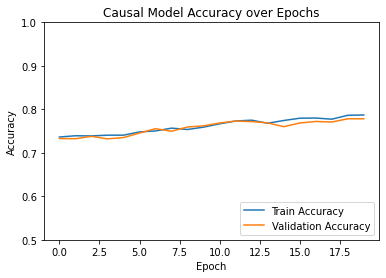

97/97 - 2s - loss: 0.4879 - accuracy: 0.7783 - 2s/epoch - 22ms/step
Causal Model Test Accuracy: 0.7783
Causal Model Test Loss: 0.4879


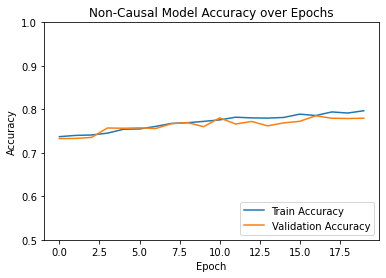

97/97 - 2s - loss: 0.4807 - accuracy: 0.7796 - 2s/epoch - 22ms/step
Non-Causal Model Test Accuracy: 0.7796
Non-Causal Model Test Loss: 0.4807


In [11]:
import matplotlib.pyplot as plt


def plot_accuracy_and_evaluate(
    model: Sequential,
    history: Sequential,
    mfcc_test: dict,
    labels_test: dict,
    model_name: str = "Model",
) -> None:
    """Plottet die Trainings- und Validierungsgenauigkeit.

    :param model: Modell, das evaluiert werden soll
    :param history: Trainingshistorie des Modells
    :param mfcc_test: Testdaten (MFCC)
    :param labels_test: Testlabels
    :param model_name: Name des Modells
    """
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.legend(loc="lower right")
    plt.show()

    test_loss, test_acc = model.evaluate(mfcc_test, labels_test, verbose=2)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Test Loss: {test_loss:.4f}")


# Beispielaufruf für das Standardmodell (Mit Zukunftsinformation)
plot_accuracy_and_evaluate(
    model, history, mfcc_test, labels_test, model_name="Causal Model"
)

# Beispielaufruf für das Causal Modell (Ohne Zukunftsinformation)
plot_accuracy_and_evaluate(
    bidirectional_model,
   bidirectional_history,
    mfcc_test,
    labels_test,
    model_name="Non-Causal Model",
)
